# Can We Predict Whether a Recipe Is Vegetarian Based Off of Ratings and Nutrition Values?

   Specifically, we want to predict whether a recipe will be vegetarian based off of 5 features: Ratings, Calories, Fat, Protein, and Sodium using a recipe data set from Epicurious in Kaggle. This is a Multivariate Binary Classification Problem. We approach this problem using four popular machine learning algorithms for classification: Logistic Regression, Support Vector Machines, RandomForest, and XGBoosting. We also use a 5-fold Kfold Cross-Validation to compare the accuracy between the algorithms.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import xgboost as gb
from xgboost import plot_tree
from xgboost import XGBClassifier
from xgboost import plot_importance
import statsmodels.api as sm

from sklearn.tree import export_graphviz
import graphviz as gz
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\juvo\Desktop\graphviz-2.38\release\bin'


import seaborn as sns

These libraries allows us to do the various algorithms and data visualization for our data analysis.

# Data Exploration and Cleaning

We first want to explore our data set and to clean the data set of outliers and NaN values if there are any.

In [42]:
recipes = pd.read_csv("C:/Users/juvo/Desktop/Projects/RecipeProject/epi_r.csv") 

print(recipes.shape) # get information of number of rows and columns
print(recipes.head()) # displays the first 5 rows of the data. 
print(recipes.tail()) # displays the last 5 rows of the data.



(20052, 680)
                                         title  rating  calories  protein  \
0              Lentil, Apple, and Turkey Wrap    2.500     426.0     30.0   
1  Boudin Blanc Terrine with Red Onion Confit    4.375     403.0     18.0   
2                Potato and Fennel Soup Hodge    3.750     165.0      6.0   
3             Mahi-Mahi in Tomato Olive Sauce    5.000       NaN      NaN   
4                    Spinach Noodle Casserole    3.125     547.0     20.0   

    fat  sodium  #cakeweek  #wasteless  22-minute meals  3-ingredient recipes  \
0   7.0   559.0        0.0         0.0              0.0                   0.0   
1  23.0  1439.0        0.0         0.0              0.0                   0.0   
2   7.0   165.0        0.0         0.0              0.0                   0.0   
3   NaN     NaN        0.0         0.0              0.0                   0.0   
4  32.0   452.0        0.0         0.0              0.0                   0.0   

   ...  yellow squash  yogurt  yonker

From the exploration, we can see that there are NaN values for calories. Likewise, we can also guess that there will be huge outliers in calories in some dishes that might affect the analysis, and so we want to remove them. (Note an alternate approach could be to fill in the missing NaN values with the average of the other data points)

In [44]:
recipes_no_na = recipes.dropna() # drops all rows with NA values 

recipes_no_outliers = recipes_no_na[recipes_no_na['calories'] < 10000] # removes outliers for 10000

Also, we can see that the rating and the nutrition facts are all in the beginning columns. The other columns appear to be mostly ingredient categorical variables so we can remove them. There is one column "Vegetarian" that we do want to remain and so we create a new dataframe with the variables we are concerned with.

In [46]:
recipes_important_variables = recipes_no_outliers.loc[0:, ['title','rating','calories','protein','fat','sodium','vegetarian']] # retains only important variables

print(recipes_important_variables.head()) # verifies whether our new dataframe is correct

                                         title  rating  calories  protein  \
0              Lentil, Apple, and Turkey Wrap    2.500     426.0     30.0   
1  Boudin Blanc Terrine with Red Onion Confit    4.375     403.0     18.0   
2                Potato and Fennel Soup Hodge    3.750     165.0      6.0   
4                    Spinach Noodle Casserole    3.125     547.0     20.0   
5                               The Best Blts    4.375     948.0     19.0   

    fat  sodium  vegetarian  
0   7.0   559.0         0.0  
1  23.0  1439.0         0.0  
2   7.0   165.0         0.0  
4  32.0   452.0         1.0  
5  79.0  1042.0         0.0  


Now we want to split our dataframes into the dependent variable("Vegetarian") and the independent variables/features (Rating, Calories, Protein, Fat, and Sodium) and convert to a form that the algorithms can use.

In [48]:
recipes_independent_variables = recipes_important_variables.loc[0:, ['rating','calories','protein','fat','sodium'] ]
recipes_dependent_variables = recipes_important_variables.loc[0:, "vegetarian" ]

recipes_independent_variables = recipes_independent_variables.values #Converts dataframe into a numpy array which the algorithms uses
recipes_dependent_variables = recipes_dependent_variables.values #Converts dataframe into a numpy array which the algorithms uses

print(recipes_independent_variables)
print(recipes_dependent_variables)

[[   2.5    426.      30.       7.     559.   ]
 [   4.375  403.      18.      23.    1439.   ]
 [   3.75   165.       6.       7.     165.   ]
 ...
 [   4.375  563.      31.      38.     652.   ]
 [   4.375  631.      45.      24.     517.   ]
 [   4.375  560.      73.      10.    3698.   ]]
[0. 0. 0. ... 0. 0. 0.]


# Algorithms Prediction Accuracy Comparison

First, we want to compare the accuracy of the algorithms to each other by using a kfold-cross validation. We settle with 5, because it's the standard fold that gives sufficient accuracy without too much computational power needed. 5-fold cross validation splits the data into 5 data sets randomly. 4 of them are training sets and are tested against the last (test) set. This process is done 5 times, with each data set becoming a test set only once, and the other 4 becoming training sets.

From the training sets, the Algorithms are making a prediction of whether a recipe is vegetarian which is determined by the features sets. Then, the predictions are tested against the test set. 

In [50]:
 def get_score(model, X_train, X_test, y_train, y_test): 
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

scores_lr = []
scores_svm = []
scores_rf = []
scores_xg = []

kf = KFold(n_splits=5, random_state=123)  #splits the data into 5, and sets a seed for reproducibility

for train_index,test_index in kf.split(recipes_independent_variables): #does and shows the 5-fold Cross Validation and appends the accuracy to the score variable arrays aboves           
    X_train, X_test, y_train, y_test = recipes_independent_variables[train_index], recipes_independent_variables[test_index], recipes_dependent_variables[train_index], recipes_dependent_variables[test_index]
    scores_lr.append(get_score(LogisticRegression(solver="lbfgs", multi_class="auto",max_iter=4000), X_train, X_test, y_train, y_test))
    scores_svm.append(get_score(SVC(gamma="scale", probability=True), X_train, X_test, y_train, y_test))
    scores_rf.append(get_score(RandomForestClassifier(n_estimators=100), X_train, X_test, y_train,y_test))
    scores_xg.append(get_score(XGBClassifier(),X_train, X_test, y_train, y_test))

print(scores_lr)
print(scores_svm)
print(scores_rf)
print(scores_xg)


[0.6513095613758283, 0.6626696118649417, 0.669611864941622, 0.6606691919191919, 0.6625631313131313]
[0.6424739665509624, 0.6554118018302304, 0.6418428526349006, 0.6530934343434344, 0.6631944444444444]
[0.7462922057431366, 0.7333543704638688, 0.7497633322814768, 0.7626262626262627, 0.7465277777777778]
[0.7166298516882297, 0.7150520668980751, 0.7052698011991164, 0.7111742424242424, 0.7095959595959596]


From the four algorithms, we see that Random Forest is the most accurate, with XGBoosting second, and logistical regression and support vector machines being close in accuracy. This was surprising because XGBoosting and RandomForest are both decision trees, where XGBoosting usually outperforms RandomForest. The reason is probably that the default parameters established in the XGBoosting Algorithm need to be tuned towards the data set. Logistic regression did not perform as well most likely due to one reason being the presense of multicollinearity, or relationships, between the independent variables with each other. For example, it is very likely that there is a positively correlated relationship between calories and ratings. When calories go up in a recipe, most likely so will the rating. Support Vector Machines also did not perform as well due to most likely the default kernel needing to be tuned towards the data set.

# Logistic Regression Analysis

[[0.51242849 0.48757151]
 [0.6214735  0.3785265 ]
 [0.52913518 0.47086482]
 ...
 [0.86734801 0.13265199]
 [0.93748576 0.06251424]
 [0.99420783 0.00579217]]
[[ 0.13366278  0.0018351  -0.0805458  -0.01168614 -0.0000678 ]]
[[1.14300731 1.00183678 0.92261265 0.98838188 0.9999322 ]]


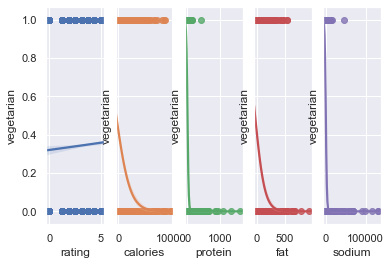

In [52]:
def get_predict_proba(model, X_train, X_test, y_train, y_test):  # creates a function to predict probability for each recipe
    model.fit(X_train, y_train)
    return model.predict_proba(X_test)

logistic_regr = LogisticRegression(solver="lbfgs", multi_class="auto",max_iter=4000)

log_regpred = get_predict_proba(logistic_regr, X_train, X_test, y_train, y_test) # gets the probability for each recipe to be vegetarian

log_reg_coef = logistic_regr.coef_ # shows the coefficients of the logistic regression

np.set_printoptions(suppress=True) # turns scientific notation off

sns.set(style="darkgrid", color_codes=True)


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, sharey=True)
sns.regplot(x=recipes_important_variables['rating'], y=recipes_important_variables['vegetarian'], ax=ax1, logistic=True)
sns.regplot(x=recipes_important_variables['calories'], y=recipes_important_variables['vegetarian'], ax=ax2, logistic=True)
sns.regplot(x=recipes_important_variables['protein'], y=recipes_important_variables['vegetarian'], ax=ax3, logistic=True)
sns.regplot(x=recipes_important_variables['fat'], y=recipes_important_variables['vegetarian'], ax=ax4, logistic=True)
sns.regplot(x=recipes_important_variables['sodium'], y=recipes_important_variables['vegetarian'], ax=ax5, logistic=True)

print(log_regpred)

print(log_reg_coef)

log_reg_coef_outputeffect = np.exp(log_reg_coef) # Increase in output odd chances for every one unit increase in the independent variable

print(log_reg_coef_outputeffect)

A major advantage of logistic regression is interpretability. For log_pred, we can see the probabilities assigned to whether or not a recipe is vegetarian. For example, the last recipe has probability [0.99420783, 0.00579217]. This means that according to the logistic regression, there's an approximate 99.4% chance that it's vegetarian, and 0.6% chance that it's not vegetarian because of the recipe's nutrition values and rating. For log_reg_coef, it gives us the coefficients of each independent variable. We look at the first independent variable rating with the coefficient of 0.13366278. For every 13.4% increase in the rating, there's an equivalent 14.3% [1.143] increase in the odds of the recipe being vegetarian.

# Support Vector Machine Analysis

In [85]:
svc = SVC(gamma="scale",probability=True).fit(X_train, y_train)

svc_predict = get_predict_proba(svc, X_train, X_test, y_train, y_test)

print("Prediction Matrix")
print(svc_predict)

Prediction Matrix
[[0.60973812 0.39026188]
 [0.73757601 0.26242399]
 [0.66765615 0.33234385]
 ...
 [0.77483604 0.22516396]
 [0.80531843 0.19468157]
 [0.81783104 0.18216896]]


Support Vector Machines is considered a "black box" algorithm, so in contrast to the logistic equation there is less interpretability especially with many features. There are no coefficients and unlike Random Forest and XGBoosting, we can't do a feature importance unless the kernel (used to help created the decision boundary between yes or no) is set to linear. However, RBF, the default kernel, since linear used too much computational power , and the RBF is generally considered the more accurate kernel if properly tuned. However we can predict the odds for each recipe of being vegeterian or not just like with logistic regression. So just like in logistic regression, we see that the [0.61100674, 0.38899326] is the yes and no odds for a recipe being vegetarian. 

# Random Forest Analysis

Calories    0.269901
Sodium      0.259634
Protein     0.239760
Fat         0.159698
Rating      0.071008
dtype: float64
Prediction Matrix
[[0.65 0.35]
 [0.74 0.26]
 [0.28 0.72]
 ...
 [0.91 0.09]
 [1.   0.  ]
 [1.   0.  ]]


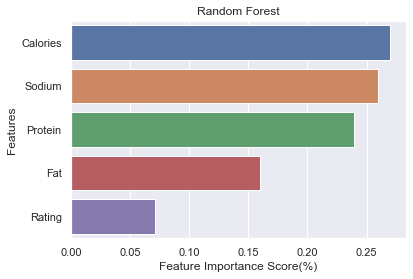

In [84]:
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train) #puts the fitted random forest algorithm with 100 trees

rf_important_features= rf.feature_importances_ #attribute that gets the value of the importance features

rf_predict = get_predict_proba(rf, X_train, X_test, y_train, y_test) #gets the predicted probability of the random forest algorithm

recipe_independent_variable_names = ["Rating", "Calories", "Protein", "Fat", "Sodium"] 
recipe_independent_variable_names_str = str(recipe_independent_variable_names) #Sets the string of the names of independent variables to attach to the feature importances

rf_important_features_str=str(rf_important_features)
rf_feature_imp = pd.Series(rf_important_features,index=recipe_independent_variable_names).sort_values(ascending=False)

print(rf_feature_imp)

print("Prediction Matrix")
print(rf_predict)

sns.barplot(x=rf_feature_imp, y=rf_feature_imp.index) #plots the feature importances

plt.xlabel('Feature Importance Score(%)')
plt.ylabel('Features')
plt.title("Random Forest")
plt.show()




                                                                              

There are no coefficients with Random Forest since it is not a regression. However we can see how important each feature is as a percentage when the decision trees make a decision. We see that calories, sodium, protein, and fat are much higher features that can affect the model if removed, and so has a huge effect on the results. 

# XGBoosting Analysis

Prediction Matrix
[[0.47166926 0.52833074]
 [0.6897092  0.31029084]
 [0.5145334  0.48546657]
 ...
 [0.9179756  0.08202442]
 [0.9837418  0.01625819]
 [0.9891112  0.01088884]]


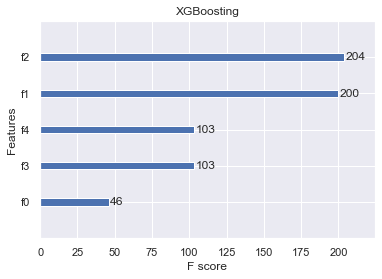

In [81]:
xgb = XGBClassifier().fit(X_train, y_train) #fits the XGBoosting Analysis

xgb_important_features = xgb.feature_importances_ #finds feature importances

xgb_pred = get_predict_proba(xgb, X_train, X_test, y_train, y_test) # find the prediction probabilities of yes and no

print("Prediction Matrix")
print(xgb_pred)



plot_importance(xgb, title = "XGBoosting") # plots the feature importance


XGboosting is a gradient boosting method that uses multiple decision trees to make the classification prediction of whether a recipe is vegetarian or not. Using the built in plot function, we can see that the general features importances is similar to Random Forest. The f0,f1,f2,f3,f4 correspond to rating, calories, protein, fat, and sodium respectively. The relative importance of the features is the concern, so the difference in the X scale is not important. We can see that protein and calories are both important features and that calories is the most important feature. Rating is also the least important feature. There is a major difference in the importance of sodium, where XGboosting rated it 3rd best and tied with fat, while Random Forest rated it a close 2nd to Calories. 

